# Estimate recombination and mutation rates from a simulated dataset
This notebook shows how to use recombulator-x to estimate recombination and mutation rates from a simulated dataset.

In [1]:
import numpy
import pandas
import recombulatorx
import recombulatorx.testing

## Simulation of STR pedigree dataset
Recombulator-x includes functions to simulate pedigrees and their STR genotypes, a useful feature when testing new approaches.
In this section we generate a pedigree file simulating 100 type I and 100 type II families with given recombination and mutation rates for six markers.

We define the simulation parameters:

In [2]:
my_recomb_rates = numpy.array([0.05, 0.3, 0.01, 0.2, 0.01])
my_mut_rates = numpy.array([1e-4, 1e-4, 1e-2, 1e-3, 1e-4, 1e-4])
n_fam_I = 100
n_fam_II = 100
ped_path = 'testsim.tsv'

numpy.random.seed(0)

The dataset is generated through the functions *generate_complex_families* and *individuals2ped*. We use the **generate_complex_families** function to simulate random individuals from a given number of informative families, following the given rates and the **individuals2ped** function to write the generated individuals to a pedigree file in TSV format, which will be saved to *ped_path*.

In [3]:
individuals = list(recombulatorx.testing.generate_complex_families(n_fam_I, n_fam_II, my_recomb_rates, my_mut_rates))
individuals[0]

('FAM_0_I', 'GRANDFATHER', None, None, array([[12., 29., 39., 43., 59., 68.]]))

In [4]:
recombulatorx.testing.individuals2ped(
    path=ped_path, 
    marker_names=[f'M{i+1}' for i, _ in enumerate(my_mut_rates)], 
    individuals=individuals,
)

The created pedigree file is a table in textual format that can be read with the pandas module. See the online documentation (Usage section) for a detailed description of the PED format. 

In [5]:
pandas.read_csv(ped_path, sep='\t').head(10)

,FID,IID,PAT,MAT,SEX,PHENO,M1-A1,M1-A2,M2-A1,M2-A2,M3-A1,M3-A2,M4-A1,M4-A2,M5-A1,M5-A2,M6-A1,M6-A2
0,FAM_0_I,GRANDFATHER,0,0,1,-9,12.0,0.0,29.0,0.0,39.0,0.0,43.0,0.0,59.0,0.0,68.0,0.0
1,FAM_0_I,MOTHER,GRANDFATHER,0,2,-9,12.0,16.0,27.0,29.0,34.0,39.0,43.0,49.0,54.0,59.0,66.0,68.0
2,FAM_0_I,SON_1,0,MOTHER,1,-9,12.0,0.0,29.0,0.0,34.0,0.0,49.0,0.0,54.0,0.0,66.0,0.0
3,FAM_0_I,FATHER_1,0,0,1,-9,14.0,0.0,21.0,0.0,37.0,0.0,46.0,0.0,58.0,0.0,66.0,0.0
4,FAM_0_I,DAUGHTER_1,FATHER_1,MOTHER,2,-9,14.0,16.0,21.0,27.0,34.0,37.0,46.0,49.0,54.0,58.0,66.0,66.0
5,FAM_0_I,FATHER_2,0,0,1,-9,18.0,0.0,25.0,0.0,36.0,0.0,48.0,0.0,54.0,0.0,67.0,0.0
6,FAM_0_I,DAUGHTER_2,FATHER_2,MOTHER,2,-9,12.0,18.0,25.0,29.0,36.0,39.0,43.0,48.0,54.0,59.0,67.0,68.0
7,FAM_1_I,GRANDFATHER,0,0,1,-9,15.0,0.0,26.0,0.0,36.0,0.0,49.0,0.0,53.0,0.0,61.0,0.0
8,FAM_1_I,MOTHER,GRANDFATHER,0,2,-9,14.0,15.0,26.0,29.0,36.0,39.0,44.0,49.0,53.0,53.0,61.0,61.0
9,FAM_1_I,SON_1,0,MOTHER,1,-9,14.0,0.0,29.0,0.0,39.0,0.0,44.0,0.0,53.0,0.0,61.0,0.0


## Dataset preprocessing

The initial steps of the Python module recombulator-x consist in reading the PED file and identifying the informative families for the estimation of recombination rates using the function **ped2graph**. This function takes a ped file as input and build a graph with the relationships. It returns a list of tuples, each composed by the graph, a dictionary (with iid as key and their tab row as value) and the family identifier. 

The pedigree file can be a *.tsv* (tab as separator value), a *.xlsx* or whatever format with a space as separator value.

For recombination, informative subfamilies are either those with:

* a phased mother and at least one son or phased daughter, called type I families,
* an unphased mother and at least two between sons and phased daughters, called type II families.

Notably, females can be phased when their father is available: in this way, they will be virtually transformed into males, thus being allowed to take part to informative families.

**Important**: Genetic markers (from the 7th column on) must be provided according to their physical genomic position. Indeed, the algorithm will infer the recombination rate between M1 and M2, M2 and M3 and so on.

In [6]:
family_graphs, marker_names = recombulatorx.ped2graph(ped_path)
len(family_graphs)

200

The function **plot_family_graph** can be used to graphically represent the reported relationships between individuals within the same family. Note that plotting requires matplotlib to be installed!

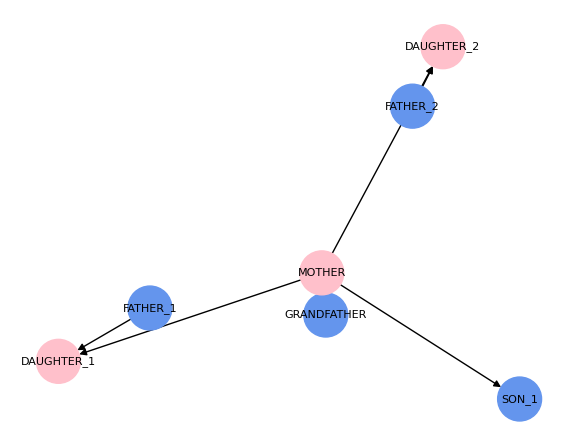

In [7]:
recombulatorx.families.plot_family_graph(family_graphs[0][1]);

The fuction **preprocess_families** will then check the consistency of each family graph and raise errors whenever necessary. For instance, an error is raised when more than two parents or same-sex parents are present in the same family. Unconnected individuals are also flagged.

In [8]:
processed_families = recombulatorx.preprocess_families(family_graphs)
len(processed_families)

200

In [9]:
processed_families[0]

ProcessedFamily(fid=('FAM_0_I', 'MOTHER'), is_mother_phased=True, mother=array([[12., 16.],
       [29., 27.],
       [39., 34.],
       [43., 49.],
       [59., 54.],
       [68., 66.]]), maternal_haplotypes=array([[12., 29., 34., 49., 54., 66.],
       [16., 27., 34., 49., 54., 66.],
       [12., 29., 39., 43., 59., 68.]]))

## Estimation

The estimation of recombination and mutation rates can be launched with the function **estimate_rates**, which estimates recombination and optionally mutation rates from a set of families. The function takes the following parameters: 

*   the families, 
*   the initial recombination rate,
*   which mutation rate needs to be estimated (no: no mutation rate estimation, one: just one mutation rate for all markers, all: a mutation rate for each marker),
*   the type of implementation (the default implementation is the one using dynamic programming).

While the numba package is not required for recombulatorx, when it is available the estimation will be much faster!

In [10]:
est_recomb_rates, est_mut_rates = recombulatorx.estimate_rates(processed_families, 0.1, 0.1, estimate_mutation_rates='all')

The output will be returned as a tuple of arrays, where the first stores the recombination rates and the second the mutation rates.

In [11]:
est_recomb_rates, est_mut_rates

(array([0.03694946, 0.32475622, 0.012345  , 0.1856328 , 0.00980138]),
 array([1.00000000e-08, 1.00000000e-08, 8.32904925e-03, 1.00000000e-08,
        2.15161190e-03, 1.00000000e-08]))

In case the dataset has been simulated, a direct comparison of initial and estimated recombination rates is possible as follows:

,simulated,estimated
0,0.05,0.036949
1,0.30,0.324756
2,0.01,0.012345
3,0.20,0.185633
4,0.01,0.009801


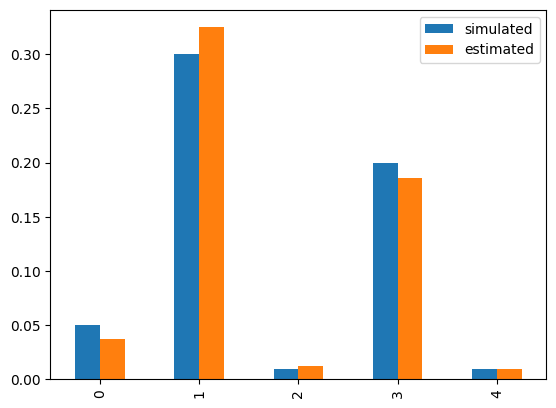

In [12]:
recomb_cmp = pandas.DataFrame({'simulated': my_recomb_rates, 'estimated': est_recomb_rates})
recomb_cmp.plot.bar()
recomb_cmp

,simulated,estimated
0,0.0001,1.000000e-08
1,0.0001,1.000000e-08
2,0.0100,8.329049e-03
3,0.0010,1.000000e-08
4,0.0001,2.151612e-03
5,0.0001,1.000000e-08


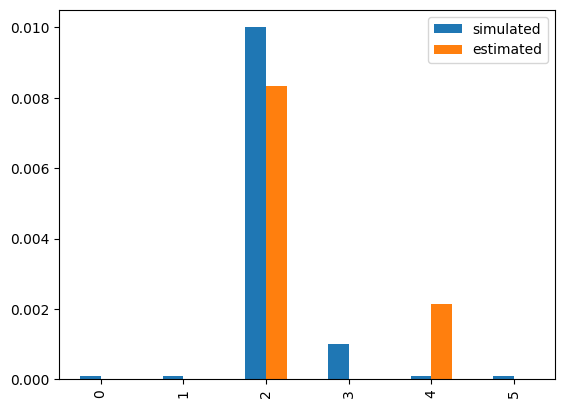

In [13]:
mut_cmp = pandas.DataFrame({'simulated': my_mut_rates, 'estimated': est_mut_rates})
mut_cmp.plot.bar();
mut_cmp

## Documentation
All functions used in this notebook have a docstring documentation.

In [14]:
help(recombulatorx.ped2graph)

Help on function ped2graph in module recombulatorx.io:

ped2graph(path)
    This function takes a pedigree file as input and encodes it as graphs.
    
    The pedigree file can be a table in .ped format (headerless and space-separated),
    in .tsv format (with header and tab-separated) or in .xlsx format (experimental).
    The format is inferred by the extension.
    
    The graphs are DiGraphs objects from the networkx module, where each node is an
    individual and edges go from parent to child. The nodes include individual information
    (sex and genotypes) as attributes.
    
    IMPORTANT: markers must be sorted by genomic position, since we assume that recombination
    happens between adjacent markers.
    
    path: str
        path to the pedigree file
    
    Returns: tuple
        a list of tuples (family ID, DiGraphs) for each family ID in the pedigree file and 
        a list of marker names.



In [15]:
help(recombulatorx.families.plot_family_graph)

Help on function plot_family_graph in module recombulatorx.families:

plot_family_graph(G, title=None)
    Plot a family graph.
    
    Requires the matplotlib module.
    
    G: networkx.DiGraph
        family graph
    title: str
        plot title
    
    Returns: matplotlib.Figure
        the family plot



In [16]:
help(recombulatorx.preprocess_families)

Help on function preprocess_families in module recombulatorx.families:

preprocess_families(family_graphs)
    Preprocess family graphs for rates estimation.
    
    Does the following preprocessing steps:
    - checks the consistency of the parsed family graphs,
    - finds all the informative subfamilies from each family,
    - phases all females using their father when available,
    - packs the inherited maternal haplotypes into a matrix
    
    family_graphs: sequence of tuples (str, networkx.DiGraph)
        sequence of tuples of family IDs and family graphs
    
    Returns: list of ProcessedFamily
        the preprocessed families



In [17]:
help(recombulatorx.estimate_rates)

Help on function estimate_rates in module recombulatorx.estimate:

estimate_rates(families, starting_recombination_rates=0.05, starting_mutation_rates=0.001, estimate_mutation_rates='no', implementation=None, optimization_method='L-BFGS-B', maxiter=1000)
    Estimate recombination and optionally mutation rates from a set of families.
    
    Estimation is done by expectation maximization, that is by finding recombination 
    and mutation rates that maximize the likelihood of observing the given families.
    Implemented using scipy.optimize.minimize to find recombination and mutation rates 
    that minimize the negative log likelihood.
    
    families: sequence of families
        the preprocessed genetic data of all the families
    starting_recombination_rates: array of shape (n_markers - 1, )
        starting probability of recombination between adjacent markers as initial 
    starting_mutation_rates: array of shape (n_markers, )
        probability of unit mutation (+1 or -1)

In [18]:
help(recombulatorx.testing.generate_complex_families)

Help on function generate_complex_families in module recombulatorx.testing:

generate_complex_families(n_fam_I: int, n_fam_II: int, recombination_rates, mutation_rates)
    Generate randomly simulated individuals from a given number of type I and II families.
    
    For each family, generate a random number of children (from a Poisson distribution with a
    mean of 2.0), with a minimum of 1 or 2 for type I or II families, respectively. A random 
    number of children (from a binomial distribution with a mean of 0.5) are set to be male and 
    the rest female. For each daughter, a father and his paternal haplotype are generated randomly.
    
    n_fam_I: int
        number of type I families
    n_fam_II: int
        number of type II families
    recombination_rates: array of shape (n_markers - 1, )
        recombination rates between adjacent markers used to generate children
    mutation_rates: array of shape (n_markers, )
        mutation rates of markers used to generate chil

In [19]:
help(recombulatorx.testing.individuals2ped)

Help on function individuals2ped in module recombulatorx.testing:

individuals2ped(path, marker_names, individuals)
    Write individuals to a pedigree file.
    
    If path ends with `.tsv' write a tab-separated table with an header row,
    otherwise a headerless space-separated table in `.ped' style.
    
    path: str
        path to the pedigree file
    marker_names: sequence of str
        names for the markers
    individuals: sequence
        individuals as generated by generate_complex_families

